# Day 12 notebook

The objectives of this notebook are to practice

* computing scores of multiple alignment columns
* progressive multiple alignment
* iterative refinement

## Modules used in this notebook

In [3]:
import matplotlib.pyplot as plt # for plotting
import fasta                    # For reading in an alignment
import submatrix                # For reading in a substitution matrix

## Multiple alignment of the CFTR protein

In this activity we will analyze a multiple alignment of the CFTR (Cystic fibrosis transmembrane conductance regulator) protein from a variety of vertebrate species.  We will implement the sum-of-pairs column scoring approaches and apply it to analyze the columns of this multiple alignment.

We will first read in the CFTR multiple alignment.

In [4]:
cftr_aligned_sequences = fasta.read_sequences_from_fasta_file("cftr_alignment.fasta")
cftr_names, cftr_alignment = zip(*cftr_aligned_sequences)

Here are the species of the CFTR proteins in this alignment:

In [5]:
print(*cftr_names, sep="\n")

Mustela putorius furo (European domestic ferret) (Mustela furo)
Papio anubis (Olive baboon)
Atelerix albiventris (Middle-African hedgehog) (Four-toed hedgehog)
Cavia porcellus (Guinea pig)
Xenopus laevis (African clawed frog)
Loxodonta africana (African elephant)
Pan troglodytes (Chimpanzee)
Canis lupus familiaris (Dog) (Canis familiaris)
Plecturocebus moloch (Dusky titi monkey) (Callicebus moloch)
Aotus nancymaae (Ma's night monkey)
Saimiri boliviensis boliviensis (Bolivian squirrel monkey)
Trichosurus vulpecula (Brush-tailed possum)
Microcebus murinus (Lesser mouse lemur) (Gray Mouse Lemur)
Macaca nemestrina (Pig-tailed macaque)
Mus musculus (Mouse)
Colobus guereza (Mantled guereza) (Eastern black-and-white colobus monkey)
Homo sapiens (Human)
Macaca fascicularis (Crab-eating macaque) (Cynomolgus monkey)
Macaca fuscata fuscata (Japanese macaque)
Sus scrofa (Pig)
Squalus acanthias (Spiny dogfish)
Chlorocebus aethiops (Green monkey) (Cercopithecus aethiops)
Didelphis virginiana (North 

And here is a slice of this alignment in a relatively interesting region:

In [6]:
def slice_alignment(alignment, start, length):
    return [s[start: start + length] for s in alignment]

slice_alignment(cftr_alignment, 660, 100)

['NSIITETLRRFSLEG---DAPVSWNETKKQSFKQT----GEFGEKRKNS-ILNPVNSIRKFSVVQKTPL--QMNGIEE-DS-DEPLERRLSLVPDGAEQG',
 'NSILTETLRRFSLEG---DAPVSWTETKKQSFKQT----GEFGEKRKNS-ILNPINSIRKFSIVQKTPL--QMNGIEE-DS-DEPLERRLSLVPDS-EQG',
 'NSILTETLRRFSLEG---DGAVSWNETRKQSFKQT----GEFGEKRKNS-ILNSMNSARKFSIVQKTTL--QMNGIEA-NS-EEPLERRLSLVPDS-ELG',
 'NSILTETLRRFSLEG---DPSVSFNETKKQSFKQT----GEFGEKRKNS-ILNSINSIRKFSIVPKTPL--QISGIEE-DS-DDPVERRLSLVPDS-EQS',
 'NSIITETLRRCSIDS---DPSAVRNEVKNKSFKQV----ADFTEKRKSS-IINPRKSSRKFSLMQKSQP--QMSGIEEEDMPAEQGERKLSLVPES-EQG',
 'NSILTETLRRFSLEG---DT-VSWNETKKQSFKQA----GEFGEKRKNS-ILNSINSIRKFSVVQKTPL--QMNGIDE-DS-DEPLERRLSLVPDS-EQG',
 'NSILTETLRRFSLEG---DAPVSWTETKKQSFKQT----GEFGEKRKNS-ILNPINSIRKFSIVQKTPL--QMNGIEE-DS-DEPLERRLSLVPDS-EQG',
 'NSIITETLRRFSLEG---DAAVPWNETKKQSFKQT----GEFGEKRKNS-ILNPINSIRKFSIVQKTPL--PMNGIEG-ES-EVPVERRLSLFPDC-EQG',
 'NSILTETLRRFSLEG---DAPVSWTETKKQSFKQT----GEFGEKRKNS-ILNSINSIRKFSIVHKTPL--QMNGIEE-DS-DEPSERRLSLIPDS-EQG',
 'NSILTETLRRFSLEG---DAPVSWTETKKQSFKQT----GEFGEKRKNS-ILN

## Test sequences for multiple alignment algorithms

Below are three sets of homologous amino acid sequences, taken from the CFTR alignment. Each sequence is a short substring of a CFTR protein sequence.  These sets will be used in testing the multiple sequence alignment algorithms that you implement below.

In [7]:
tiny_set = {
    'Zebrafish': 'SETPKPD',
    'Human': 'TEGKPTKS',
    'Mouse': 'TEESMYTQI'
}
tiny_seqs = sorted(tiny_set.values())

small_set = {
    'Guinea pig': 'EEGAPVKS',
    'Zebrafish': 'SETPKPD',
    'Human': 'TEGKPTKS',
    'Mouse': 'TEESMYTQI',
    'Spiny dogfish': 'PEGSETK'
}
small_seqs = sorted(small_set.values())

large_set = {
    'Guinea pig': 'FSIVPKTPLQISGIEEDSDDPVERRL',
    'Zebrafish': 'ASFIQVPEEEVRRTLPDRKF',
    'Human': 'FSIVQKTPLQMNGIEEDSDEPLERRL',
    'Mouse': 'ISIVQKTPLCIDGESDDLQEKRL',
    'Small-eared galago': 'FSVVQKTPLPMNGIDEEDSEEPVERRL',
    'Rat': 'ISIVQKTPLSIEGESDDLQERRL',
    'Spiny dogfish': 'FSLVQTAMSYPQTNGMEDATSEPGERHF'
}
large_seqs = sorted(large_set.values())

## Sum of pairs scoring

### PROBLEM 1: Computing the sum of pairs score of a column (1 POINT)

Write a function `sum_of_pairs_column_score` below, which takes as input a column from a multiple alignment (represented as a string) and a substitution matrix, and computes the sum of pairs score of that column.  Recall that the sum of pairs score for a column is defined as:

$S_{sum\_of\_pairs}(m_i) = \sum_{k < l} S(m_i^k, m_i^l)$

where $S(m_i^k, m_i^l)$ is the substitution score of the character in the $k$th row with the character in the $l$th row.

For simplicity, we will simply treat a space ('-') like any other character in a column, and will add the space character to the substitution matrix, with the score of aligning a character to a space being the space score of a linear gap penalty function.

First we will set up the substitution matrix, which will be the BLOSUM62 matrix with a space score of -2 added to it.

In [8]:
def submatrix_with_spaces(matrix, space_score):
    """Returns an extended substitution matrix representing a linear gap penalty function."""
    extended_matrix = matrix.copy()
    chars = {a for (a, b) in matrix}
    for a in chars:
        extended_matrix[a, '-'] = space_score
        extended_matrix['-', a] = space_score
    extended_matrix['-', '-'] = 0
    return extended_matrix

blosum62 = submatrix.read_substitution_matrix("BLOSUM62.txt")
space_score = -2
blosum62_with_spaces = submatrix_with_spaces(blosum62, space_score)

In [9]:
def sum_of_pairs_column_score(column, matrix):
    """Returns the sum of pairs score of an alignment column.
    
    Args:
        column: a column of a multiple alignment, represented as a string with the ith character
                specifying the character from the ith sequence in the alignment.
        matrix: a substitution matrix, represented as a dictionary
    Returns:
        The sum of pairs score of the column."""
    ###
    ### YOUR CODE HERE
    sum = 0
    #print(column)
    
    for i, x in enumerate(column): 
        for j, y in enumerate(column):
            if i < len(column) or j < len(column):
                if i > j:
                    sum = sum + matrix[column[i],column[j]]
    #print(sum)
    return sum

In [10]:
# tests for sum_of_pairs_column_score
assert sum_of_pairs_column_score('SQSQ', blosum62_with_spaces) == 9
assert sum_of_pairs_column_score('WWWWWW', blosum62_with_spaces) == 165
assert sum_of_pairs_column_score('ACDEFG', blosum62_with_spaces) == -27
assert sum_of_pairs_column_score('GEGEKRK', blosum62_with_spaces) == 4
assert sum_of_pairs_column_score('--S-', blosum62_with_spaces) == -6
print("SUCCESS: sum_of_pairs_column_score passed all tests!")

SUCCESS: sum_of_pairs_column_score passed all tests!


### Sum of pairs scores of columns in the CFTR alignment
We will now use your `sum_of_pairs_column_score` to compute and examine the sum of pairs scores of the columns within the CFTR alignment.

In [11]:
def transpose_alignment(alignment):
    """Returns a column-based alignment from a row-based alignment or vice versa"""
    return list(map(''.join, zip(*alignment)))

cftr_alignment_columns = list(zip(*cftr_alignment))
sum_of_pairs_scores = [sum_of_pairs_column_score(column, blosum62_with_spaces) for column in cftr_alignment_columns]

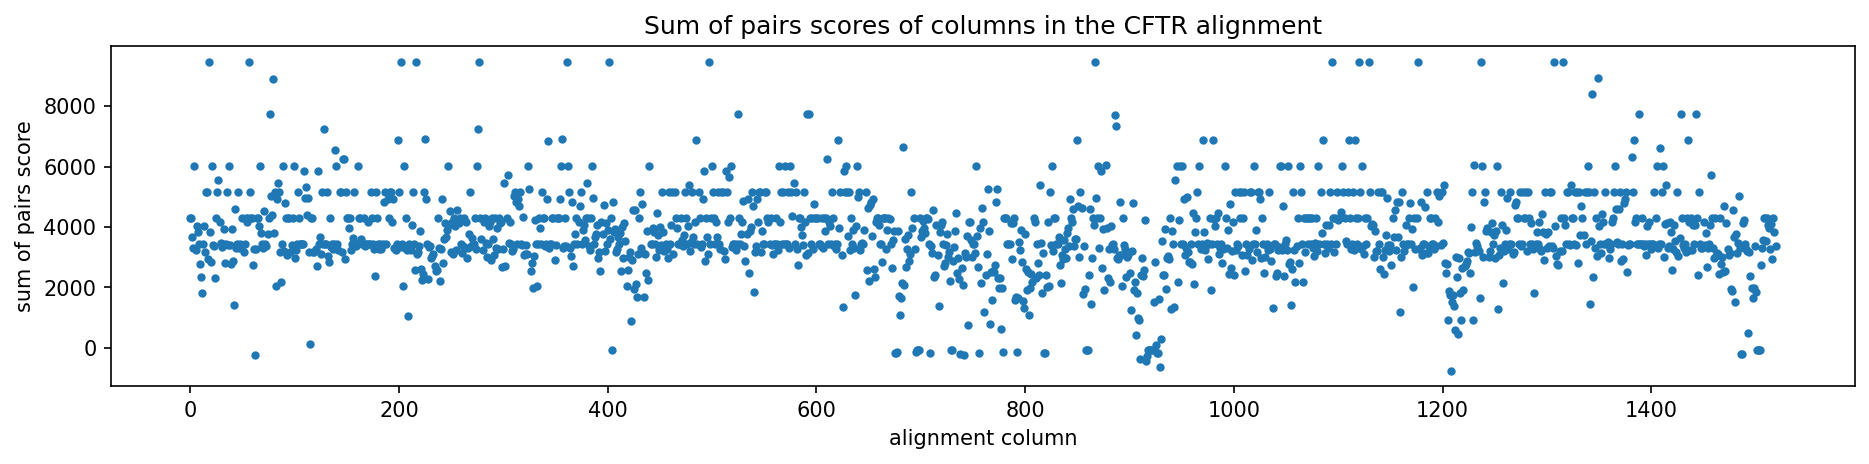

In [12]:
plt.figure(figsize=(15, 3), dpi=150)
plt.plot(sum_of_pairs_scores, ".")
plt.xlabel("alignment column")
plt.ylabel("sum of pairs score")
plt.title("Sum of pairs scores of columns in the CFTR alignment")
plt.show()

What does this plot tell you regarding which regions of the CFTR proteins are more or less conserved?

###
### *Your thoughts here*
###


## Multiple alignment algorithms

### A core global pairwise alignment function
Below is a function, `align_global`, that implements standard global pairwise alignment, but that generically supports aligning two alignments to each other.  You will use this function to implement both progressive alignment and iterative refinement.

In [13]:
def align_global(x, y, substitution_matrix):
    """Computes a global pairwise alignment of sequences/alignments x and y
    
    Uses a linear gap scoring function with the space score encoded in the given substitution matrix.
    In the case of multiple optimal alignments, this function returns a "middle-road" 
    alignment (prefers match/mismatch first).
    
    Args:
        x: an alignment/sequence represented as a list of strings. A single 
           unaligned sequence should be represented by a list with a single element (the sequence).
        y: an alignment/sequence represented as a list of strings. A single 
           unaligned sequence should be represented by a list with a single element (the sequence).
        substitution_matrix: the substitution matrix, represented as a dictionary 
    Returns:
        An alignment, represented as a list of aligned strings of the same length.
    """
    # create lists of the columns of the two alignments
    xt, yt = transpose_alignment(x), transpose_alignment(y)
    num_rows, num_cols = len(xt) + 1, len(yt) + 1
    x_all_spaces, y_all_spaces = '-' * len(x), '-' * len(y)
    m = matrix(num_rows, num_cols) # score matrix
    t = matrix(num_rows, num_cols) # traceback pointer matrix

    # constants representing the traceback pointers, with higher
    # values representing higher priority for traceback in case of ties
    M, IX, IY = 3, 2, 1
    
    # A function that scores the alignment of two columns
    def score_column_pair(x_column, y_column):
        return sum(substitution_matrix[a, b] for a in x_column for b in y_column)

    # initialization
    m[0][0] = 0
    for i in range(1, num_rows):
        m[i][0] = m[i - 1][0] + score_column_pair(xt[i - 1], y_all_spaces)
        t[i][0] = IX
    for j in range(1, num_cols):
        m[0][j] = m[0][j - 1] + score_column_pair(x_all_spaces, yt[j - 1])
        t[0][j] = IY
  
    # main fill
    for i in range(1, num_rows):
        for j in range(1, num_cols):
            m[i][j], t[i][j] = max((m[i - 1][j - 1] + score_column_pair(xt[i - 1], yt[j - 1]),     M),
                                   (m[i - 1][j]     + score_column_pair(xt[i - 1], y_all_spaces), IX),
                                   (m[i][j - 1]     + score_column_pair(x_all_spaces, yt[j - 1]), IY))

    # traceback
    columns = []
    i, j = num_rows - 1, num_cols - 1
    while i > 0 or j > 0:
        traceback = t[i][j]
        if traceback == M:
            i -= 1
            j -= 1            
            columns.append(xt[i] + yt[j])
        elif traceback == IX:
            i -= 1
            columns.append(xt[i] + y_all_spaces)
        elif traceback == IY:
            j -= 1
            columns.append(x_all_spaces + yt[j])
        else:
            assert False
    
    return transpose_alignment(reversed(columns))

def matrix(num_rows, num_cols, initial_value=None):
    """Returns a matrix (a list of rows, each of which is a list) 
    with num_rows and num_cols and with initial_value in each entry"""
    return [[initial_value] * num_cols for i in range(num_rows)]

## PROBLEM 2: Progressive alignment (1 POINT)
Write a function that computes a multiple alignment of a set of sequences using the progressive alignment strategy.  Your function should take in an "alignment order" which specifies the ordering of the pairwise alignments to perform.  For example, if there are four sequences, the alignment order 

`[((1,),   (3,)),
 ((0,),   (2,)),
 ((1, 3), (0, 2))]`
 
 would specify the following sequence of pairwise alignments:
 
 1. align sequence 1 to sequence 3
 2. align sequence 0 to sequence 2
 3. align the partial alignment of sequences 1 and 3 to the partial alignment of sequences 0 and 2
 
 

In [14]:
def align_progressive(sequences, alignment_order, substitution_matrix):
    """Computes a multiple alignment with the progressive alignment strategy
    and a given ordering of pairwise alignments to perform.
    
    Args:
        sequences: a list of strings
        alignment_order: a list of two-element tuples, with each element
                         of a tuple being a tuple of integer indices, 
                         specifying a partial alignment of a subset of
                         the sequences (indicated by the indices). Each element
                         of the alignment_order list specifies the next pair of
                         partial alignments to align with each other.
        substitution_matrix: a substitution matrix, represented as a dictionary
    Returns:
        A multiple alignment, represented by a list of aligned strings.
    """
    # we will store the partial alignments that we construct in a dictionary with tuples
    # of (sorted) indices of the sequences in each partial alignment as keys
    # we start with each sequence as its own partial alignment
    partial_alignments = {(i,): [seq] for i, seq in enumerate(sequences)}
    
    ###
    ### YOUR CODE HERE
    for aligned_set1, aligned_set2 in alignment_order:
        combined_set = tuple(sorted(aligned_set1 + aligned_set2))
        combined_alignment = align_global(partial_alignments[aligned_set1],
                                          partial_alignments[aligned_set2],
                                          substitution_matrix) 
        partial_alignments[combined_set] = combined_alignment
    
    # by this point there should be an entry in partial_alignments for the tuple
    # containing the indices of all sequences
    full_set = tuple(range(len(sequences)))
    full_alignment = partial_alignments[full_set]
    # return the full alignment with the sequences in the same order as in the input
    return sorted(full_alignment, key=lambda s: sequences.index(s.replace('-', '')))

In [15]:
# tests for align_progressive
tiny_order1 = [((0,), (1,)), 
               ((0, 1), (2,))]
tiny_result1 = ['S-E-TPKPD-', 
                'TEE-SMYTQI', 
                'T-EGKP-TKS']
assert align_progressive(tiny_seqs, tiny_order1, blosum62_with_spaces) == tiny_result1

tiny_order2 = [((0,), (2,)), 
               ((0, 2), (1,))]
tiny_result2 = ['SE-TP--KPD', 
                'TEESMYTQ-I', 
                'TEGKP-TK-S']
assert align_progressive(tiny_seqs, tiny_order2, blosum62_with_spaces) == tiny_result2

tiny_order3 = [((1,), (2,)), 
               ((1, 2), (0,))]
tiny_result3 = ['S-ET-P-KPD', 
                'TEESMYTQ-I', 
                'T-EGKPTK-S']
assert align_progressive(tiny_seqs, tiny_order3, blosum62_with_spaces) == tiny_result3

small_order1 = [((0,), (1,)),
                ((2,), (3,)),
                ((2, 3), (4,)),
                ((0, 1), (2, 3, 4))]
    
small_result1 = ['E-EGAP-VKS', 
                 'P-EGSE-TK-', 
                 'S-E-TPKPD-', 
                 'TEE-SMYTQI', 
                 'T-EGKP-TKS']
assert align_progressive(small_seqs, small_order1, blosum62_with_spaces) == small_result1
print("SUCCESS: align_progressive passed all tests!")

SUCCESS: align_progressive passed all tests!


## PROBLEM 3: Iterative refinement (1 POINT)
We will next write a function for performing iterative refinement on a multiple alignment.  The main function, `refine_alignment` is written for you below.  You are to write `realign_first_sequence` which takes as input an alignment and realigns the first sequence in the alignment back to the remainder of the alignment.  You will need to make sure that you:

1. Remove space characters from the first sequence before aligning it back
2. Remove columns with all space characters in the partial alignment that results after removing the first sequence.
3. Do not modify the object (a list) referenced by the `alignment` input argument

In [16]:
def refine_alignment(alignment, substitution_matrix):
    """Performs iterative refinement on a multiple alignment.
    
    Args:
        alignment: a multiple alignment, represented by a list of aligned strings.
        substitution_matrix: a substitution matrix, represented by a dictionary.
    Returns:
        A multiple alignment, represented by a list of aligned strings."""
    previous_alignment = None
    current_alignment = alignment
    while current_alignment != previous_alignment:
        previous_alignment = current_alignment
        for i in range(len(current_alignment)):
            # realign the first sequence
            current_alignment = realign_first_sequence(current_alignment, substitution_matrix)
            # move first sequence to the bottom of the alignment
            current_alignment = current_alignment[1:] + current_alignment[:1]
    return current_alignment

In [17]:
def realign_first_sequence(alignment, substitution_matrix):
    """Returns a new alignment that results from realigning the first
    sequence of the given alignment back to the remaining alignment.
    
    Args:
        alignment: a multiple alignment, represented by a list of aligned strings.
        substitution_matrix: a substitution matrix, represented by a dictionary.
    Returns:
        A multiple alignment, represented by a list of aligned strings."""
    ###
    ### YOUR CODE HERE
    ###
    first_seq = alignment[0].replace('-', '')
    remaining_alignment = remove_all_space_cols(alignment[1:])
    return align_global([first_seq], remaining_alignment, substitution_matrix)

def remove_all_space_cols(alignment):
    all_space_col = '-' * len(alignment)
    return transpose_alignment(column for column in transpose_alignment(alignment) if column != all_space_col)


In [18]:
# tests for realign_first_sequence
tiny_result1 = ['S-E-TPKPD-', 
                'TEE-SMYTQI', 
                'T-EGKP-TKS']
tiny_refine1 = ['S-E-TP--KPD', 
                'TEE-SMYTQ-I', 
                'T-EGKP-TK-S']
tiny_result1_copy = tiny_result1[:]
assert realign_first_sequence(tiny_result1, blosum62_with_spaces) == tiny_refine1
assert tiny_result1 == tiny_result1_copy, "You modified the input alignment"

tiny_result2 = ['SE-TP--KPD', 
                'TEESMYTQ-I', 
                'TEGKP-TK-S']
tiny_refine2 = ['SE-TP--KPD', 
                'TEESMYTQ-I', 
                'TEGKP-TK-S']
tiny_result2_copy = tiny_result2[:]
assert realign_first_sequence(tiny_result2, blosum62_with_spaces) == tiny_refine2
assert tiny_result2 == tiny_result2_copy, "You modified the input alignment"

# for the last test we will run refine_alignment rather than realign_first_sequence
small_result1 = ['E-EGAP-VKS', 
                 'P-EGSE-TK-', 
                 'S-E-TPKPD-', 
                 'TEE-SMYTQI', 
                 'T-EGKP-TKS']
small_refine1 = ['EEGAP-VK-S', 
                 'PEGSE-TK--', 
                 'SE-TP--KPD', 
                 'TEESMYTQ-I', 
                 'TEGKP-TK-S']
small_result1_copy = small_result1[:]
refine_alignment_result = refine_alignment(small_result1, blosum62_with_spaces)
assert small_result1 == small_result1_copy, "You modified the input alignment"
assert refine_alignment_result == small_refine1, "refine_alignment output is incorrect"
print("SUCCESS: realign_first_sequence passed all tests!")

SUCCESS: realign_first_sequence passed all tests!


## CHALLENGE: Find the best multiple alignment of the "large" test set
Using your progressive alignment and iterative refinment functions above, try your hand at finding the best scoring alignment of the "large" test set.  Use the function below to compare the scores of your alignments.

In [19]:
def score_alignment_sum_of_pairs(alignment, substitution_matrix):
    """Returns the sum of pairs score for the given alignment using the given
    substitution matrix, which must be extended for a linear gap penalty function."""
    return sum(sum_of_pairs_column_score(column, substitution_matrix) 
               for column in transpose_alignment(alignment))

In [29]:

align_global('CAT', '-CAT-', blosum62_with_spaces)

['C', 'A', 'T', '-', 'C', 'A', 'T', '-']